Create the paths for storing data.

In [399]:
import pandas as pd
import numpy as np

from os import sep, makedirs
from os.path import dirname, realpath, join, isdir

uppath = lambda _path, n: sep.join(_path.split(sep)[:-n]) # moves the path 'n' levels up the directory

__file__ = dirname(realpath('__file__'))
data_parent_directory = uppath(__file__, 2)
data_directory = join(data_parent_directory, 'Data')
housing_directory = join(data_directory, 'housing')

Extract the CSV files and store in the given locations.

In [400]:
from zipfile import ZipFile

def extract_housing_data(zipfile_directory, housing_directory):
    
    if not isdir(housing_directory):
        makedirs(housing_directory)
    
    housing_path = join(zipfile_directory, 'housing.zip')
    with ZipFile(housing_path, 'r') as zip:
            zip.extractall(path=housing_directory)

Loads the extracted titanic data into two Pandas DFs: train and test

In [401]:
def load_housing_data(housing_directory):
    train_csv = join(housing_directory, "train.csv")
    test_csv = join(housing_directory, "test.csv")
    return pd.read_csv(train_csv), pd.read_csv(test_csv)

extract_housing_data(data_directory, housing_directory)

train, test = load_housing_data(housing_directory)

In [402]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

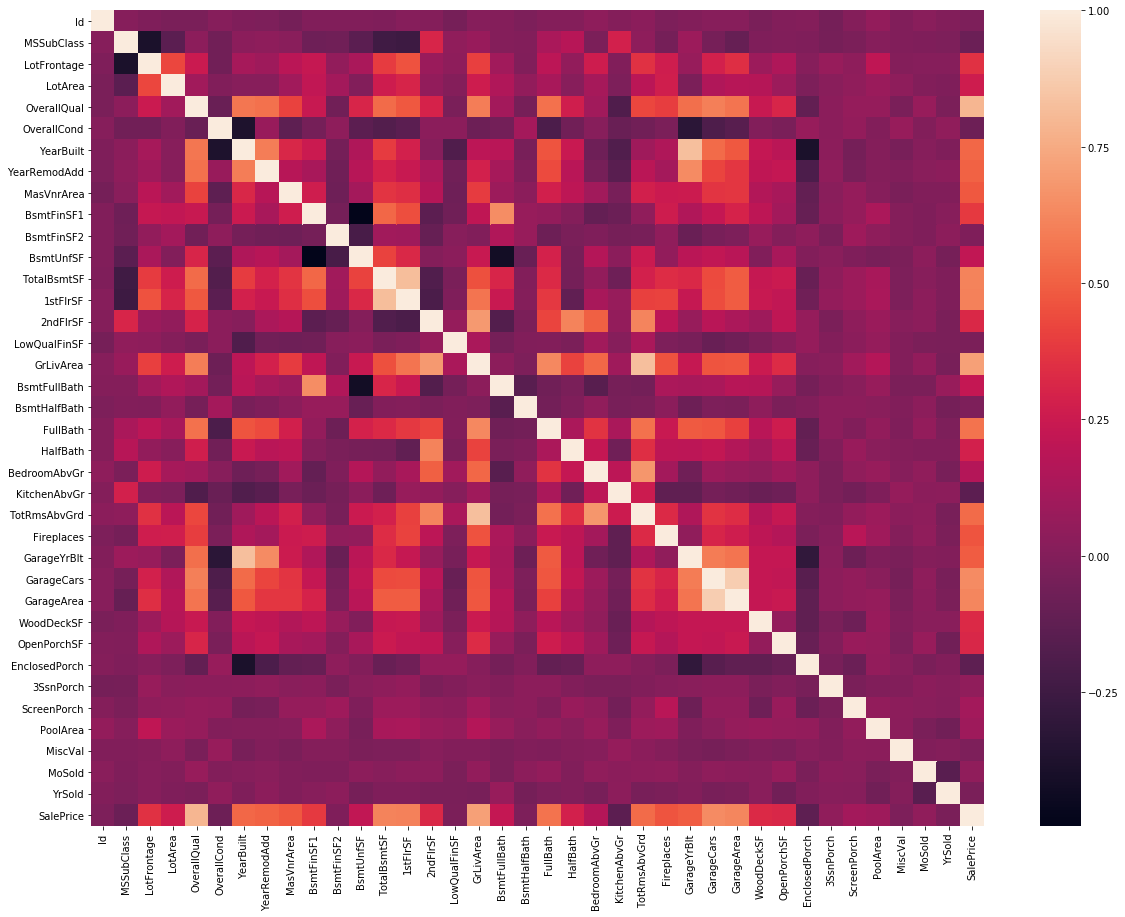

In [403]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ax, fig = plt.subplots(1,1, figsize=(20, 15))
sns.heatmap(data=train.corr())

Findings:

**Strong -ve Correlation:**
<br>EnclosedPorch & YearBuilt
<br>GarageYrBlt & OverallCond
<br>YearBuilt & OverallCond (Stronger)
<br>MSSubClass & LotFrontage

**Weak -ve Correlation:**
<br>MSSubClass & TotalBsmtSF
<br>MSSubClass & 1stFlrSF (Although 2ndFlrSF has good +ve correlation with MSSubClass)

**Strong +ve Correlation:**
<br>SalePrice with OverallQual, GrLivArea, GarageCars/GarageArea, TotalBsmtSF, 1stFlrSF, FullBath, YearRemodAdd, TotRmsAbvGrd
<br>TotalBsmtSF & 1stFlrSF
<br>OverallQual with YearBuilt, GrLivArea, GarageCars/GarageArea, FullBath
<br>GarageYrBlt & YearBuilt
<br>GarageYrBlt & YearRemodAdd
<br>FullBath & YearBuilt
<br>GrLivArea & 1stFlrSF
<br>GrLivArea & 2ndFlrSF
<br>GrLivArea & FullBath
<br>TotRmsAbvGrd & BedroomAbvGrd
<br>HalfBath & 2ndFlrSF

Let's try to visualize some of these. To see what they're actually like.

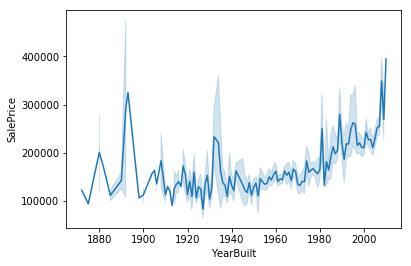

In [404]:
sns.lineplot(x=train['YearBuilt'], y=train['SalePrice'])

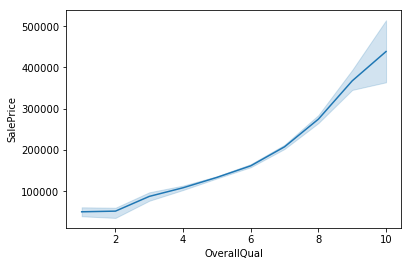

In [405]:
sns.lineplot(x=train['OverallQual'], y=train['SalePrice'])

This looks real good!

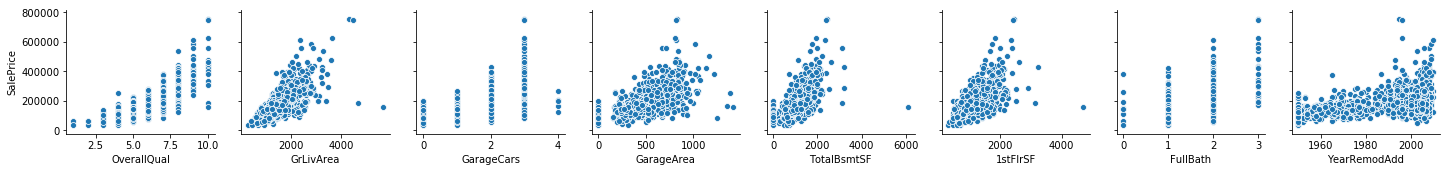

In [406]:
sns.pairplot(train, y_vars=['SalePrice'], x_vars=['OverallQual', 'GrLivArea', 'GarageCars','GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearRemodAdd'])

YearRemodAdd seems to have little to no effect on the SalePrice. Rest of the features are fairly +vely correlated. Garage Cars seem to peak at 3 and come down again.

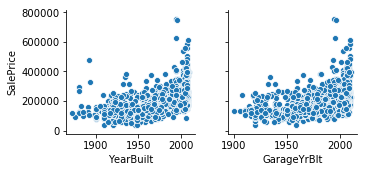

In [407]:
sns.pairplot(train, y_vars=['SalePrice'], x_vars=['YearBuilt', 'GarageYrBlt'])

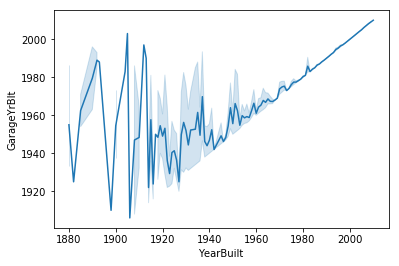

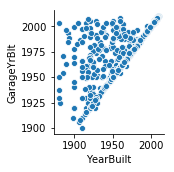

In [408]:
sns.lineplot(x=train['YearBuilt'], y=train['GarageYrBlt'])
sns.pairplot(train, x_vars=['YearBuilt'], y_vars=['GarageYrBlt'])

In [409]:
(train['YearBuilt'] == train['GarageYrBlt']).value_counts()

True     1089
False     371
dtype: int64

For most of the houses the YearBuilt and GarageYrBlt is the same. So don't consider them different. 
<br>Condense them into one attribute or leave out one of them. I think YearBuilt is better correlated with SalePrice.

---
Let's clean our data and then proceed with feature engineering.
<br>We'll see how many zero and missing values are present.

In [410]:
print('\t\tZero\t\tMissing')

cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearRemodAdd']

for col in train:
    if isinstance(train[col][0], np.int64) or isinstance(train[col][0], np.float64):
        zero_val = (train[col] == 0.00).astype(int).sum(axis=0)
    elif isinstance(train[col][0], np.object):
        zero_val = (train[col] == '').astype(int).sum(axis=0)
    mis_val = train[col].isnull().sum()
    if not (mis_val == 0):
        print(col+'\t'+str(zero_val)+'\t'+str(mis_val))

		Zero		Missing
LotFrontage	0	259
Alley	0	1369
MasVnrType	0	8
MasVnrArea	861	8
BsmtQual	0	37
BsmtCond	0	37
BsmtExposure	0	38
BsmtFinType1	0	37
BsmtFinType2	0	38
Electrical	0	1
FireplaceQu	0	690
GarageType	0	81
GarageYrBlt	0	81
GarageFinish	0	81
GarageQual	0	81
GarageCond	0	81
PoolQC	0	1453
Fence	0	1179
MiscFeature	0	1406


Although, here zero is a meaningful value, for example: Fireplace == 0 means that the house has no fireplace.
<br>And missing values probably mean that that particular feature isn't present for a house.
<br>So let's handle it accordingly.

---
Handling missing values for categorical data

In [411]:
# These features' values need to be replaced with 'NA' wherever they are Nan
# Here Nan simply means that that feature doesn't exist. Eg:- No pool, No garage etc.
featuresNA = ['MiscFeature', 'Fence', 'PoolQC' , 'GarageType','GarageFinish', 'GarageQual', 'GarageCond', 'FireplaceQu', 'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for feature in featuresNA:
    train[feature].fillna('Na', inplace=True)
    test[feature].fillna('NA', inplace=True)


# Impute the single Nan value of 'Electrical' feature with 'SBrkr'
# Most of the houses that have 'GasA' type heating and Central Air conditioning have 'Sbrkr' type of electrical wiring.
# In fact, that would be the median as well.
# So we'll impute with just that.
train['Electrical'].fillna('SBrkr', inplace=True)
test['Electrical'].fillna('SBrkr', inplace=True)

In [412]:
min(train.LotFrontage)

21.0

---
Handling missing values for numeric data

In [413]:
numeric_data = train.select_dtypes([np.number])
numeric_data.columns[numeric_data.isnull().sum() > 0]

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

Only 3 features have Nan values. 

0.4260950187718087

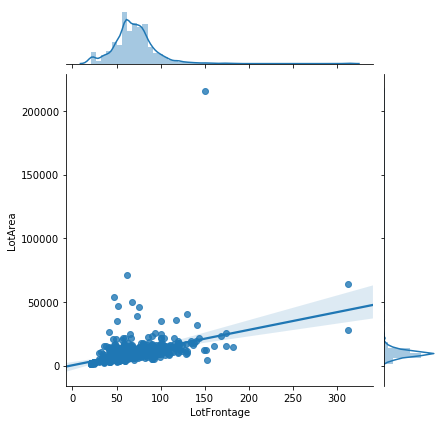

In [414]:
sns.jointplot(y="LotArea", x="LotFrontage", data=train, kind="reg")
train.corr().LotFrontage.LotArea

<br>I'll be dropping the LotFrontage feature entirely.
<br>It has an okayish correlation with LotArea, so that feature should make-up for this. Their jointplot clearly shows signs of a trend.
<br>Although, I could've imputed it with 0's and combined these two features into a stronger one,
but Frontage, to me, seems to be just the width of the house which is usually part of it's area ( for a regular shaped house ).
<br>We'll ignore it for now and maybe come back to it later.

In [415]:
train['MasVnrType'].isnull().sum()

8

In [416]:
train['GarageYrBlt'].fillna(0, inplace=True)
test['GarageYrBlt'].fillna(0, inplace=True)

# There are only 8 records without this value. Let's simply drop them.
train.dropna(subset=['MasVnrType'], inplace=True)

train.drop(columns=['LotFrontage'], axis=1, inplace=True)
test.drop(columns=['LotFrontage'], axis=1, inplace=True)

train.shape

(1452, 80)

## Feature Engineering

I'll look at sets of related features and I'll see if I can enhance them in any way.

Let's begin small. Take,

Fireplaces
<br>FireplaceQu

It makes sense to have good quality fireplace. Having **Fireplaces * FireplaceQu** as a feature would make more sense.

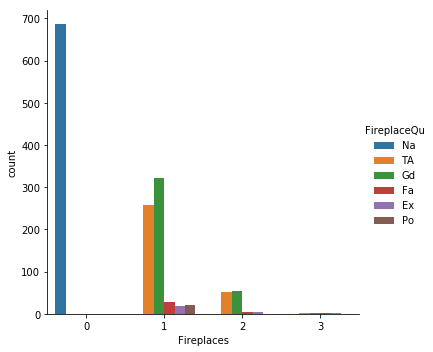

In [417]:
sns.catplot(x='Fireplaces', hue='FireplaceQu', data=train, kind='count')

Judging by the plot, there are just as many 'Average' fireplaces as there are 'Good'
<br>And there are just as many 'Poor' fireplaces as there are 'Excellent'. These need to be differentiated.
<br>Multiplying as suggested before can make a huge difference.

*Although*, we assume that 2 fair enough fireplaces are just as good as 1 good fireplace.
<br>This is valid because both of them are similarly correlated with SalePrice, meaning that they are treated equally.

In [418]:
train['FireplaceQu'].replace(to_replace={'Na':0, 'NA': 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
test['FireplaceQu'].replace(to_replace={'Na':0, 'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
test['FireplaceQu'] = test['FireplaceQu'].astype(np.int64)

train['FireplaceScore'] = train.apply(lambda x: x['Fireplaces'] * x['FireplaceQu'], axis=1)
test['FireplaceScore'] = test.apply(lambda x: x['Fireplaces'] * x['FireplaceQu'], axis=1)

In [419]:
train['FireplaceQu'].value_counts()

0    686
4    378
3    311
2     33
5     24
1     20
Name: FireplaceQu, dtype: int64

Great! We can further reduce them and put them under 4-5 broad categories.
<br>But keep in mind that this variable **should not be on-hot-encoded**. It's ordinal.

Refer to <a href="https://elitedatascience.com/feature-engineering">this link</a> and the <a href="https://elitedatascience.com/feature-engineering-best-practices">additional resources</a> at the end for more info.

In [420]:
'''
0   - 686
1-2 - 48
3   - 259
4   - 326
5-7 - 71
>=8 - 62
'''

def getFireplaceScore(x):
    if(x == 0):
        return 1
    elif(x >= 1 and x <= 2):
        return 2
    elif(x == 3):
        return 3
    elif(x == 4):
        return 4
    elif(x >= 5 and x <= 7):
        return 5
    else:
        return 6


train['FireplaceScore'] = train.apply(lambda x: getFireplaceScore(x['FireplaceScore']), axis=1)
test['FireplaceScore'] = test.apply(lambda x: getFireplaceScore(x['FireplaceScore']), axis=1)

In [421]:
train.corr().FireplaceScore.SalePrice

0.519978948969871

That's an okay correlation. Maybe in the model it'll do better alongwith other features.
<br>Let's look at OverallQual and OverallCond now

0.7899971370270409


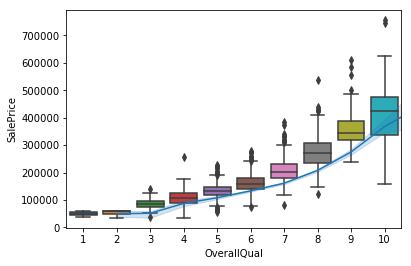

In [422]:
sns.boxplot(x='OverallQual', y='SalePrice', data=train)
sns.lineplot(x='OverallQual', y='SalePrice', data=train)
print(train.corr().OverallQual.SalePrice)

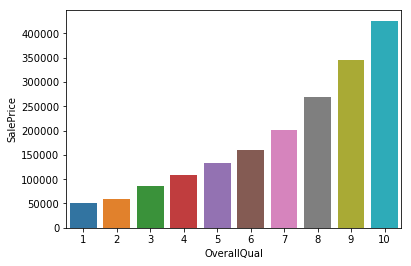

In [423]:
overall_qual = numeric_features.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
sns.barplot(x=overall_qual.index, y='SalePrice', data=overall_qual)

-0.07629370215546846


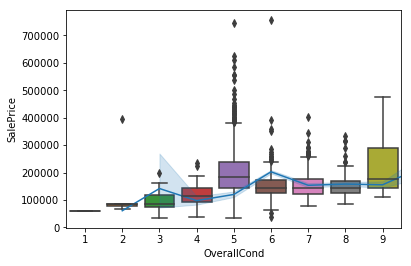

In [424]:
sns.boxplot(x='OverallCond', y='SalePrice', data=train)
sns.lineplot(x='OverallCond', y='SalePrice', data=train)
print(train.corr().OverallCond.SalePrice)

In [425]:
train.corr().OverallCond.OverallQual

-0.0906283953467841

They're poorly correlated with each other and OverallQual has really good correlation with SalePrice.
<br>I'll just ignore OverallCond.

0.8312173269874843


GarageYrBlt    0.486220
GarageCars     0.636118
GarageArea     0.607210
Name: SalePrice, dtype: float64

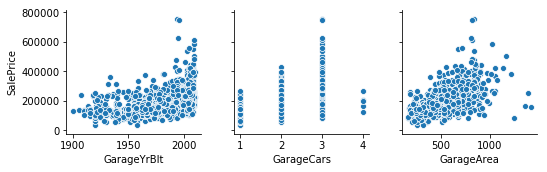

In [426]:
# GarageType
# GarageFinish
# GarageCars
# GarageArea
# GarageQual
# GarageCond

sns.pairplot(train[train['GarageYrBlt'] > 0], y_vars=['SalePrice'], x_vars=[ 'GarageYrBlt', 'GarageCars','GarageArea'])

print(train[train['GarageYrBlt'] > 0].corr().GarageCars.GarageArea)
train[train['GarageYrBlt'] > 0].corr().SalePrice[[ 'GarageYrBlt', 'GarageCars','GarageArea']]

Looking at GarageYrBlt first:

GarageYrBlt and YearBuilt are correlated.
<br>So here's what I'm gonna do,
<br>I can use such categories for YearBuilt and I'll drop GarageYrBlt.
<br>But to differentiate houses with Garages and without, I'll use a binary valued column for GaragePresent.

In [427]:
train['GaragePresent'] = train.apply(lambda x: 1 if x['GarageArea'] > 0 else 0, axis=1)
test['GaragePresent'] = test.apply(lambda x: 1 if x['GarageArea'] > 0 else 0, axis=1)

In [428]:
def getDecadeFromYear(x):
    
    if(x < 1900):
        return 1
    elif(x < 2000):
        return int(int(x % 1900) / 10) + 1
    else:
        return 11

train['BuiltDecade'] = train.apply(lambda x: getDecadeFromYear(x['YearBuilt']), axis=1)
test['BuiltDecade'] = test.apply(lambda x: getDecadeFromYear(x['YearBuilt']), axis=1)

train['BuiltDecade'].value_counts()

11    381
8     188
7     175
6     166
10    163
3      97
5      79
9      61
2      58
4      54
1      30
Name: BuiltDecade, dtype: int64

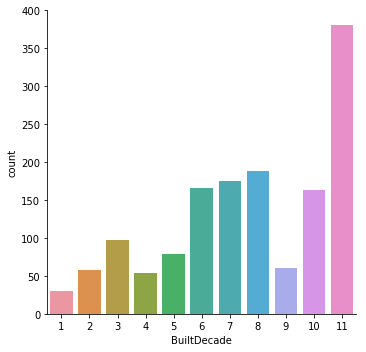

In [429]:
sns.catplot(x='BuiltDecade', kind='count', data=train)

In [430]:
def getHouseAge(x):
    if(x<1920):
        return 1
    elif(x>=1920 and x < 1950):
        return 2
    elif(x>=1950 and x < 1970):
        return 3
    elif(x>=1970 and x<2000):
        return 4
    elif(x>=2000):
        return 5

train['HouseAge'] = train.apply(lambda x: getHouseAge(x['YearBuilt']), axis=1)
test['HouseAge'] = test.apply(lambda x: getHouseAge(x['YearBuilt']), axis=1)

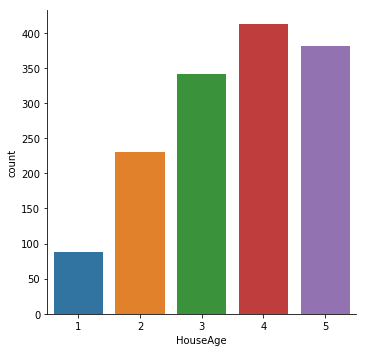

In [431]:
sns.catplot(x='HouseAge', kind='count', data=train)

I've tweaked the limits for putting them into different categories in such a way that there's enough in each bin for the model <br>to learn correctly. This is to avoid overfitting.

---
Some Garage related features

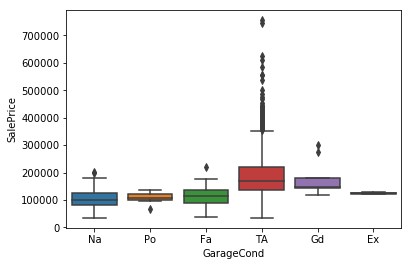

In [432]:
sns.boxplot(x='GarageCond', y='SalePrice', data=train, order=['Na','Po','Fa','TA','Gd','Ex'])

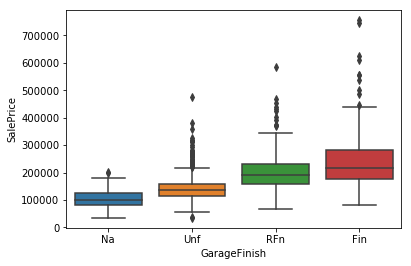

In [433]:
sns.boxplot(x='GarageFinish', y='SalePrice', data=train, order=['Na', 'Unf', 'RFn', 'Fin'])

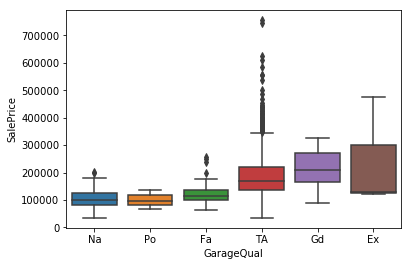

In [434]:
sns.boxplot(x='GarageQual', y='SalePrice', data=train, order=['Na','Po','Fa','TA','Gd','Ex'])

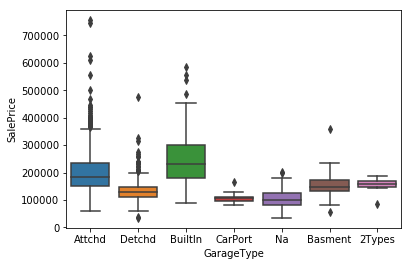

In [435]:
sns.boxplot(x='GarageType', y='SalePrice', data=train)

In [436]:
train['GarageType'].value_counts()

Attchd     863
Detchd     387
BuiltIn     87
Na          81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

People don't seem to care about the Garage Condition. Heck, it's for car and junk anyway.
<br>Garage Quality and Garage Finish seems to matter a little.
<br>I'll use Garage Type to create a new feature: GarageAccess
<br>People would prefer garages that are easily accessible from the inside the house rather than being detached.
<br>The data seems to suggest the same.

In [437]:
def getGarageAccessType(x):
    
    if(x == 'Na'):
        return 0
    elif(x in ['Detchd', 'CarPort']):
        return 1
    else:
        return 2

train['GarageAccess'] = train.apply(lambda x: getGarageAccessType(x['GarageType']), axis=1)
test['GarageAccess'] = test.apply(lambda x: getGarageAccessType(x['GarageType']), axis=1)

0.45890468329281764

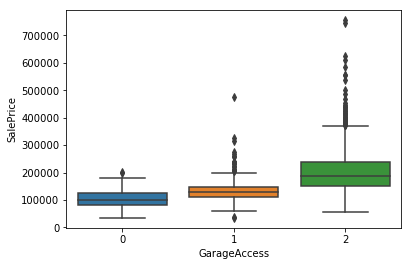

In [438]:
sns.boxplot(x='GarageAccess', y='SalePrice', data=train)
train.corr().GarageAccess.SalePrice

There seems to be a vague trend, so I'm assuming it checks out.

I'm gonna leave GarageFinish and GarageQual as it is. I'll let the model learn their importance.

---
Looking at PoolArea and PoolQC

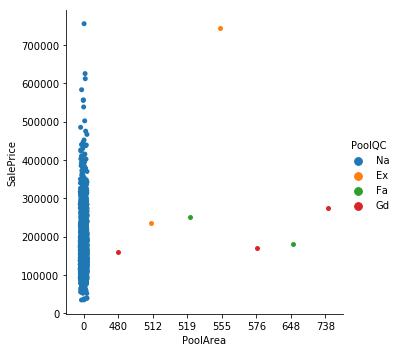

In [439]:
sns.catplot(x='PoolArea', hue='PoolQC', y='SalePrice', data=train)

Woah, that's hard to understand. No particular trend here.
<br>Logic dictates that price should be higher for a house with a pool.
<br>But we don't have enough data to make assumptions.
<br>I think I'll drop them, because I don't want the model to overfit to it.

---
Let's look at MoSold and YrSold

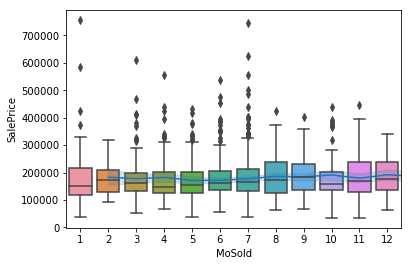

In [440]:
sns.boxplot(x='MoSold', y='SalePrice', data=train)
sns.lineplot(x='MoSold', y='SalePrice', data=train)

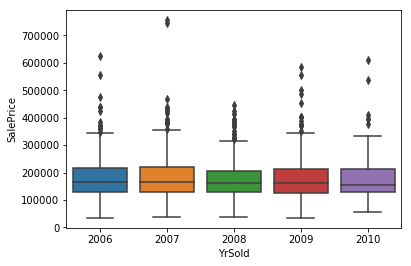

In [441]:
sns.boxplot(x='YrSold', y='SalePrice', data=train)
sns.lineplot(x='YrSold', y='SalePrice', data=train)

Wow, month and year sold don't seem to matter at all.
<br>But there isn't a single period when the prices were too high / too low? Like an inflation?
<br>I'll have to probe deeper.

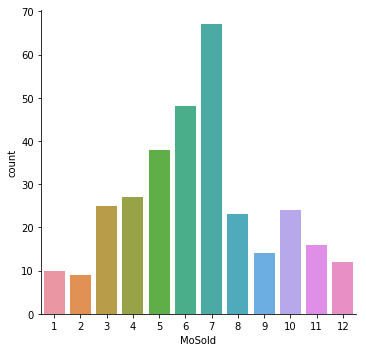

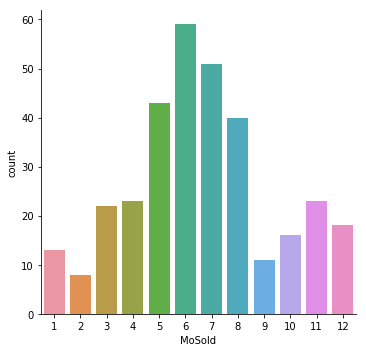

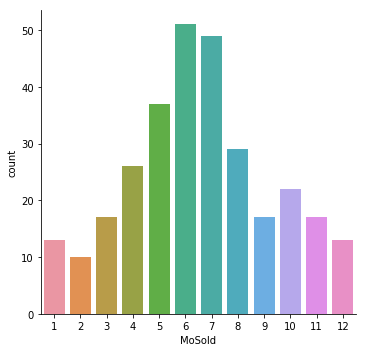

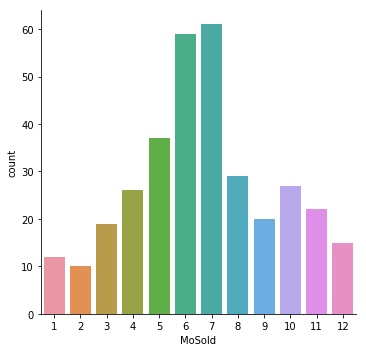

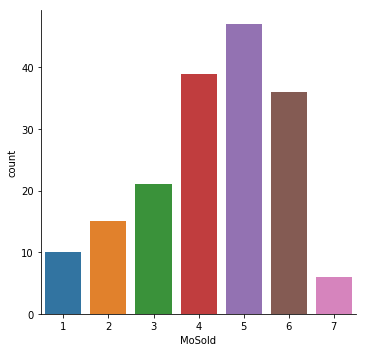

In [442]:
for year in [2006,2007,2008,2009,2010]:
    sns.catplot(x='MoSold', kind='count', data=train[train['YrSold'] == year])

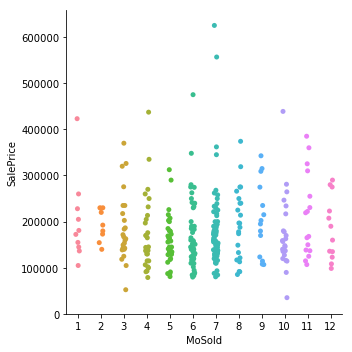

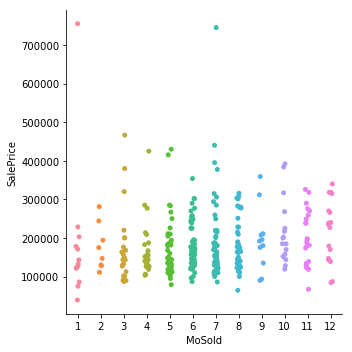

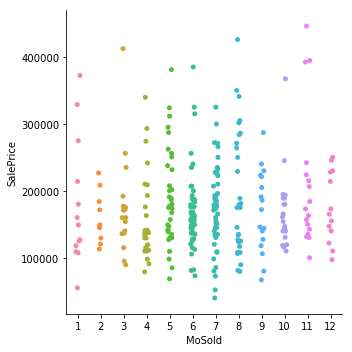

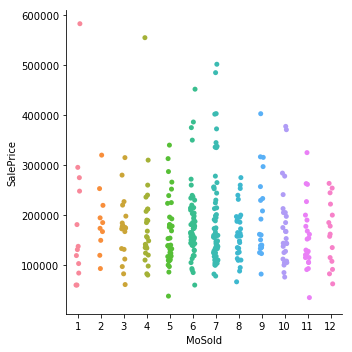

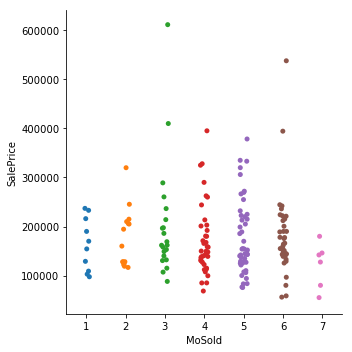

In [443]:
for year in [2006,2007,2008,2009,2010]:
    sns.catplot(x='MoSold', y='SalePrice', data=train[train['YrSold'] == year])

Seems like more houses are sold in the middle months, 6-7.
<br>But the Sale Prices are the same as for other months. So I'll just leave it.

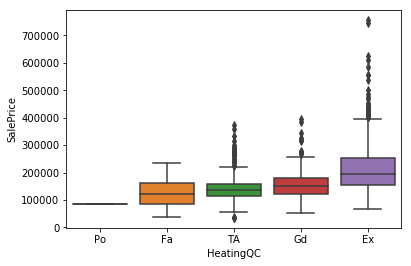

In [444]:
sns.boxplot(x='HeatingQC', y='SalePrice', data=train, order=['Po','Fa','TA','Gd','Ex'])

This is good.  I'll use this.

---
All basement related features.
<br>BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF

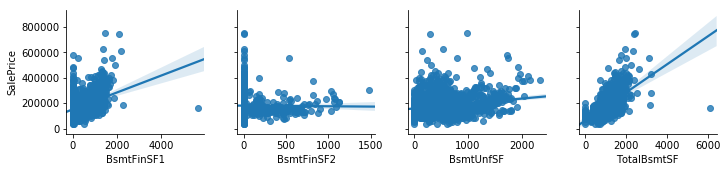

In [445]:
sns.pairplot(train, x_vars=['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF'], y_vars=['SalePrice'], kind='reg')

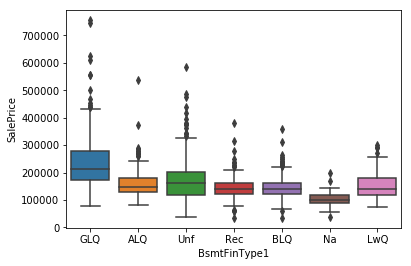

In [446]:
sns.boxplot(x='BsmtFinType1', y='SalePrice', data=train)

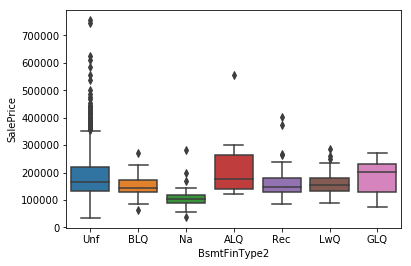

In [447]:
sns.boxplot(x='BsmtFinType2', y='SalePrice', data=train)

In [448]:
train.corr().SalePrice[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']]

BsmtFinSF1     0.383977
BsmtFinSF2    -0.010316
BsmtUnfSF      0.215740
TotalBsmtSF    0.612971
Name: SalePrice, dtype: float64

TotalBsmtSF looks good. I'll use that.

---
Next up:
<br>PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch

In [449]:
train[['PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].head()

,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
0,Y,0,61,0,0,0
1,Y,298,0,0,0,0
2,Y,0,42,0,0,0
3,Y,0,35,272,0,0
4,Y,192,84,0,0,0


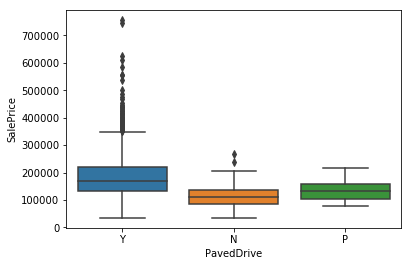

In [450]:
sns.boxplot(x='PavedDrive', y='SalePrice', data=train)

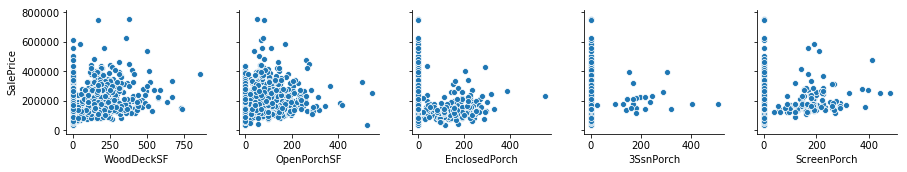

In [451]:
sns.pairplot(train, x_vars=['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], y_vars=['SalePrice'])

In [452]:
train['TotalPorch'] = train.apply(lambda x: x['WoodDeckSF'] + x['OpenPorchSF'] + x['EnclosedPorch'] + x['3SsnPorch'] + x['ScreenPorch'], axis=1)
test['TotalPorch'] = test.apply(lambda x: x['WoodDeckSF'] + x['OpenPorchSF'] + x['EnclosedPorch'] + x['3SsnPorch'] + x['ScreenPorch'], axis=1)

0.38948333181099604

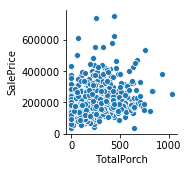

In [453]:
sns.pairplot(train, x_vars=['TotalPorch'], y_vars=['SalePrice'])
train.corr().TotalPorch.SalePrice

In [454]:
train.corr().SalePrice[['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']]

WoodDeckSF       0.324650
OpenPorchSF      0.311268
EnclosedPorch   -0.128778
3SsnPorch        0.045247
ScreenPorch      0.113044
Name: SalePrice, dtype: float64

I have fused the porch areas into a single feature, TotalPorch.
<br>This new feature seems to have better correlation with SalePrice, than any of those individual features.
<br>I'll keep this and drop the rest.
<br>As of PavedDrive, I'll keep it that way.

---
Let's Living Rooms and Total Rooms above ground

0.5363108545464506


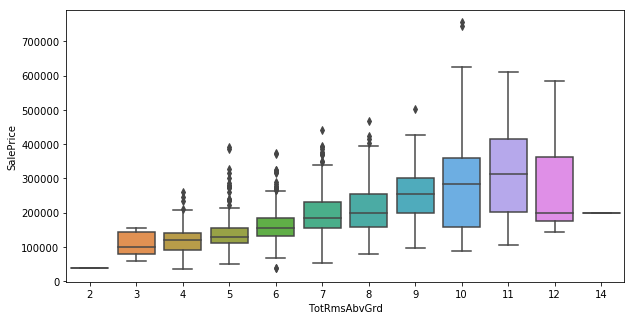

In [455]:
figure, axis = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(x='TotRmsAbvGrd', y='SalePrice', data=train, ax=axis)
print(train.corr().SalePrice.TotRmsAbvGrd)

Although the correlation is less, I think it can still capture the essence of the relation.
<br>So I'll keep it.

---
Finally moving on, Next up:
<br>MasVnrType,
MasVnrArea,
ExterQual,
ExterCond,

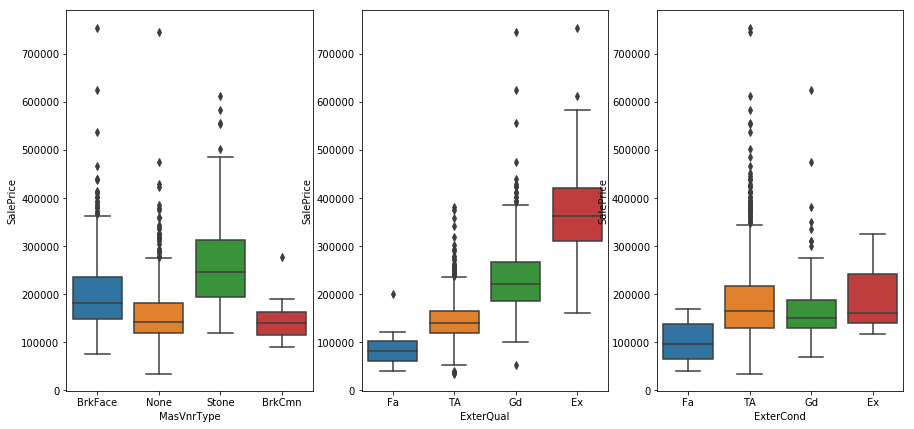

In [456]:
figure, axis = plt.subplots(1,3, figsize=(15,7))
sns.boxplot(x='MasVnrType', y='SalePrice', data=train, ax=axis[0])
sns.boxplot(x='ExterQual', y='SalePrice', data=train, ax=axis[1], order=['Fa', 'TA', 'Gd', 'Ex'])
sns.boxplot(x='ExterCond', y='SalePrice', data=train, ax=axis[2], order=['Fa', 'TA', 'Gd', 'Ex'])

In [457]:
train.corr().SalePrice.MasVnrArea

0.4774930470957107

ExterQual looks good.

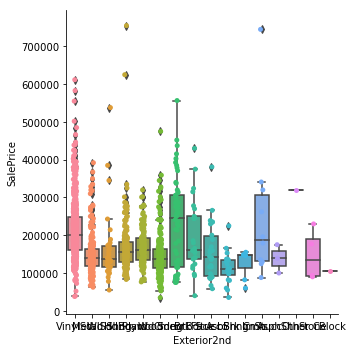

In [458]:
sns.catplot(x='Exterior2nd', y='SalePrice', data=train)
sns.boxplot(x='Exterior2nd', y='SalePrice', data=train)

I'll keep Exterior1st and Exterior2nd unchanged as well.
<br>Let's see RoofMatl and RoofStyle

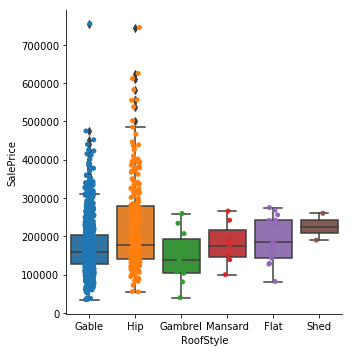

In [459]:
sns.catplot(x='RoofStyle', y='SalePrice', data=train)
sns.boxplot(x='RoofStyle', y='SalePrice', data=train)

RoofStlye doesn't seem to matter that much.
<br>RoofMatl has most of the data belonging to only one material category, making judgement difficult.
<br>I don't think these features matter at all, I'll drop them and see what happens.

---
Next up:
<br>BldgType, HouseStyle

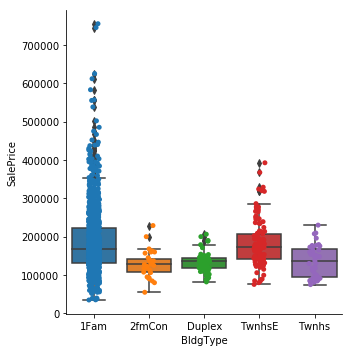

In [460]:
sns.catplot(x='BldgType', y='SalePrice', data=train)
sns.boxplot(x='BldgType', y='SalePrice', data=train)

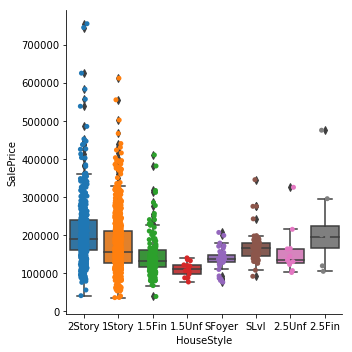

In [461]:
sns.catplot(x='HouseStyle', y='SalePrice', data=train)
sns.boxplot(x='HouseStyle', y='SalePrice', data=train)

In [462]:
train['HouseStyle'].value_counts()

1Story    721
2Story    442
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

There's nothing much I can do about these features (HouseStyle, BldgType). I'll keep them unchanged.

In [464]:
train['Street'] = pd.get_dummies(train['Street'], drop_first=True)
test['Street'] = pd.get_dummies(test['Street'], drop_first=True)

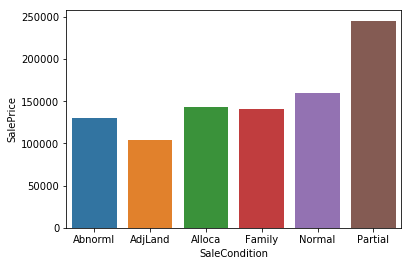

In [465]:
condition = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
sns.barplot(x=condition.index, y='SalePrice', data=condition)

Partial seems a cut above the rest. So let's differentiate it.

In [466]:
train['SaleCondition'] = train['SaleCondition'].apply(lambda x: 1 if x == 'Partial' else 0)
test['SaleCondition'] = test['SaleCondition'].apply(lambda x: 1 if x == 'Partial' else 0)

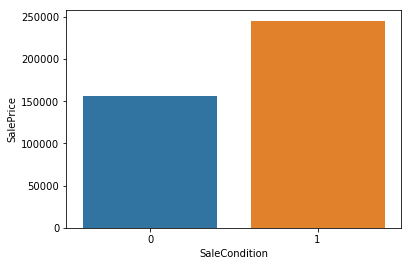

In [467]:
condition = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
sns.barplot(x=condition.index, y='SalePrice', data=condition)

There's actually a lot more analysis that I've deleted to make this more meaningful and concise. But it's fun to poke around and create new features.

---
### Modeling

In [468]:
train.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,YrSold,SaleType,SaleCondition,SalePrice,FireplaceScore,GaragePresent,BuiltDecade,HouseAge,GarageAccess,TotalPorch
0,1,60,RL,8450,1,Na,Reg,Lvl,AllPub,Inside,...,2008,WD,0,208500,1,1,11,5,2,61
1,2,20,RL,9600,1,Na,Reg,Lvl,AllPub,FR2,...,2007,WD,0,181500,3,1,8,4,2,298
2,3,60,RL,11250,1,Na,IR1,Lvl,AllPub,Inside,...,2008,WD,0,223500,3,1,11,5,2,42
3,4,70,RL,9550,1,Na,IR1,Lvl,AllPub,Corner,...,2006,WD,0,140000,4,1,2,1,1,307
4,5,60,RL,14260,1,Na,IR1,Lvl,AllPub,FR2,...,2008,WD,0,250000,3,1,11,5,2,276


1.8840445160660748

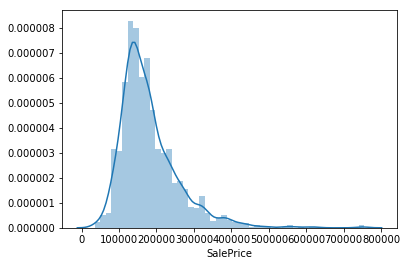

In [469]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.distplot(train['SalePrice'])
train['SalePrice'].skew()

0.12194740900374888

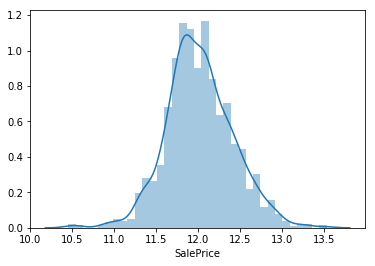

In [470]:
sns.distplot(np.log(train['SalePrice']))
np.log(train['SalePrice']).skew()

The SalePrice was right skewed. Applying log transform centeres it nicely. Evidently, the skew reduces.

In [471]:
# train['SalePrice'] = np.log(train['SalePrice'])
numeric_features = train.select_dtypes(np.number)
numeric_features.head()

,Id,MSSubClass,LotArea,Street,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,MoSold,YrSold,SaleCondition,SalePrice,FireplaceScore,GaragePresent,BuiltDecade,HouseAge,GarageAccess,TotalPorch
0,1,60,8450,1,7,5,2003,2003,196.0,706,...,2,2008,0,208500,1,1,11,5,2,61
1,2,20,9600,1,6,8,1976,1976,0.0,978,...,5,2007,0,181500,3,1,8,4,2,298
2,3,60,11250,1,7,5,2001,2002,162.0,486,...,9,2008,0,223500,3,1,11,5,2,42
3,4,70,9550,1,7,5,1915,1970,0.0,216,...,2,2006,0,140000,4,1,2,1,1,307
4,5,60,14260,1,8,5,2000,2000,350.0,655,...,12,2008,0,250000,3,1,11,5,2,276


In [472]:
numeric_features.corr()['SalePrice'].sort_values(ascending=False).head()

SalePrice      1.000000
OverallQual    0.789997
GrLivArea      0.710080
GarageCars     0.639686
GarageArea     0.622492
Name: SalePrice, dtype: float64

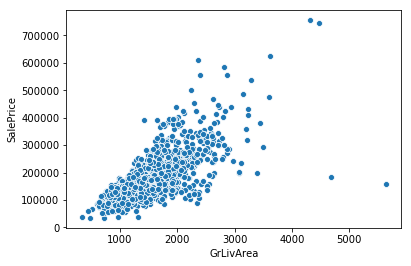

In [473]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)

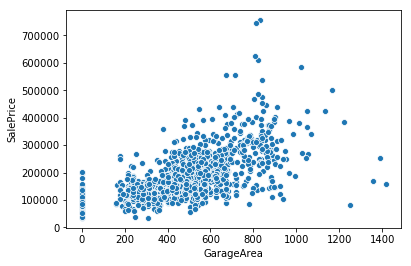

In [474]:
sns.scatterplot(x='GarageArea', y='SalePrice', data=train)

Some outliers are apparent. I've used Isolation Forest before, but now I'll keep it simple, manual outlier removal considering only GarageArea and GrLivArea.

c:\users\avinash akella\canopy\notebooks\practice:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


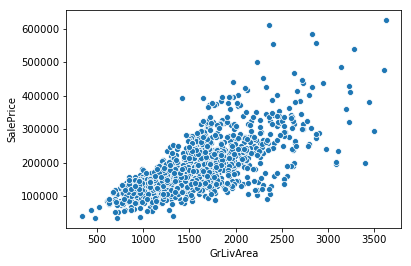

In [475]:
train_copy = train[train['GarageArea'] < 1200][train['GrLivArea'] < 4000]
test_copy = test.copy()
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_copy)

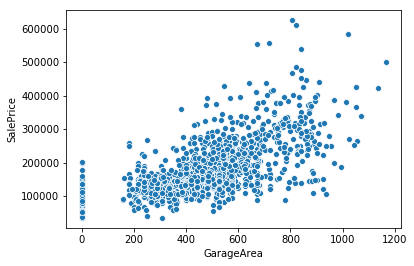

In [476]:
sns.scatterplot(x='GarageArea', y='SalePrice', data=train_copy)

Looks good!

In [477]:
categorical = train_copy.select_dtypes(exclude=[np.number])
categorical.head()

,MSZoning,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType
0,RL,Na,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Typ,Attchd,RFn,TA,TA,Y,Na,Na,Na,WD
1,RL,Na,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,Typ,Attchd,RFn,TA,TA,Y,Na,Na,Na,WD
2,RL,Na,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Typ,Attchd,RFn,TA,TA,Y,Na,Na,Na,WD
3,RL,Na,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Typ,Detchd,Unf,TA,TA,Y,Na,Na,Na,WD
4,RL,Na,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Typ,Attchd,RFn,TA,TA,Y,Na,Na,Na,WD


Filling null values.

In [478]:
train_copy = train_copy.select_dtypes(include=[np.number]).interpolate().dropna()
test_copy = test_copy.select_dtypes(include=[np.number]).interpolate().dropna()

sum(train_copy.isnull().sum())

0

In [479]:
to_drop = ['SalePrice', 'Id']
y = np.log(train_copy['SalePrice'])
x = train_copy.drop(to_drop, axis=1)

In [480]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.33)

In [481]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)

lr.score(x_test, y_test)

0.8757196345089694

In [482]:
from sklearn.metrics import mean_squared_error

preds = lr.predict(x_test)
mean_squared_error(y_test, preds)

0.019336147292715808

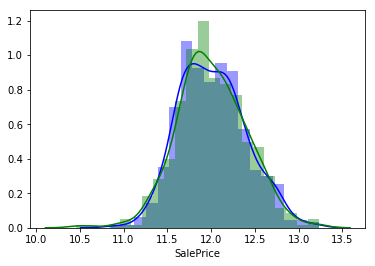

In [483]:
sns.distplot(preds, color='blue')
sns.distplot(y_test, color='green')

It looks Great! Let's make a submission!

In [484]:
submission = pd.read_csv(join(housing_directory, 'sample_submission.csv'))

lr = LinearRegression()
lr.fit(x, y)

pred = lr.predict(test_copy.drop('Id', axis=1))

submission['SalePrice'] = np.exp(pred)

submission.to_csv(join(housing_directory, 'submission.csv'), index=False)

This did best so far. A good task for later would be to include some of the categorical features as well.

---
Let's try with Gradient Bossting as well.

In [486]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

gbr.fit(x_train, y_train)

preds = gbr.predict(x_test)
mean_squared_error(y_test, preds)

0.018438670659507463

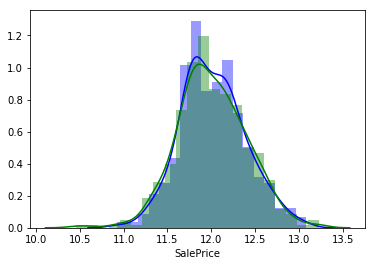

In [487]:
sns.distplot(preds, color='blue')
sns.distplot(y_test, color='green')

In [488]:
submission = pd.read_csv(join(housing_directory, 'sample_submission.csv'))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
gbr.fit(x, y)

pred = gbr.predict(test_copy.drop('Id', axis=1))

submission['SalePrice'] = np.exp(pred)

submission.to_csv(join(housing_directory, 'submission.csv'), index=False)

Linear Regression was simpler andm better. This probably overfit.

---
Let's try PCA!

In [489]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
reduced_train = pca.fit_transform(x)
reduced_test = pca.transform(test_copy.drop('Id', axis=1))

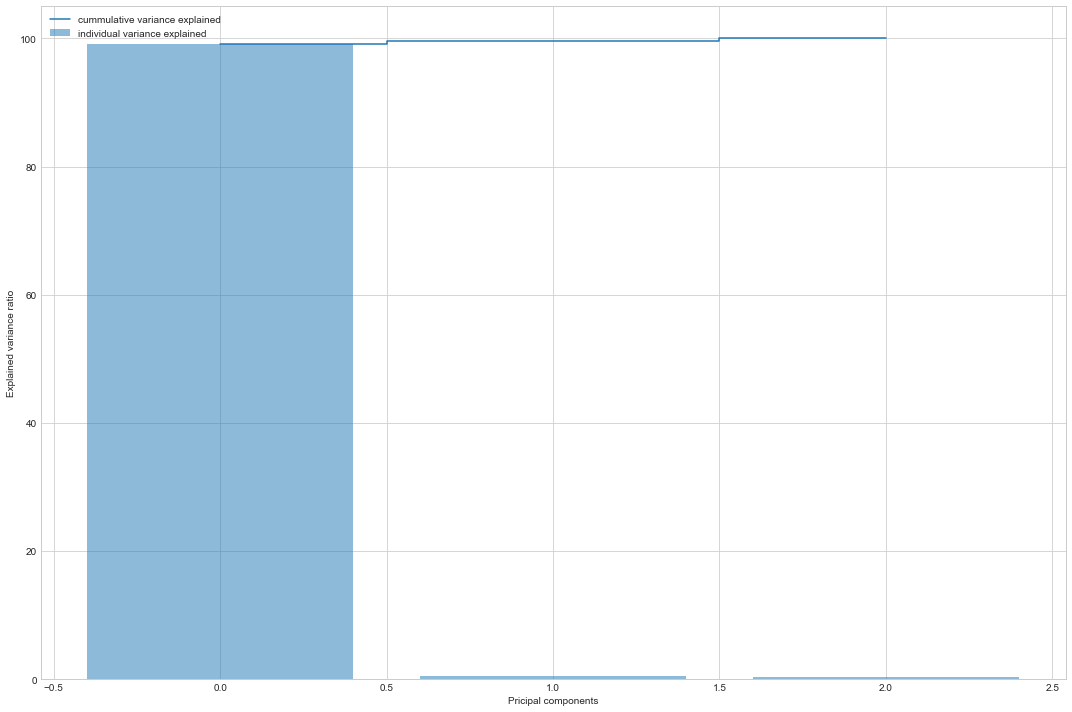

In [490]:
explainedVariance = pca.explained_variance_
totalVarianceExplained = sum(explainedVariance)

percentVarianceExplained = [(i / totalVarianceExplained) * 100 for i in explainedVariance]

cummulativeVarianceExplained = np.cumsum(percentVarianceExplained)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(15, 10))
    
    plt.bar(range(len(percentVarianceExplained)), percentVarianceExplained, alpha=0.5, align='center', label='individual variance explained')
    plt.step(range(len(cummulativeVarianceExplained)), cummulativeVarianceExplained, where='mid', label='cummulative variance explained')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Pricipal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [491]:
reduced_train.shape

(1444, 3)

In [492]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(reduced_train, y, random_state=42, test_size=0.33)

In [493]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)

lr.score(x_test, y_test)

0.7005498980565741

In [494]:
from sklearn.metrics import mean_squared_error

preds = lr.predict(x_test)
mean_squared_error(y_test, preds)

0.0465899118909071

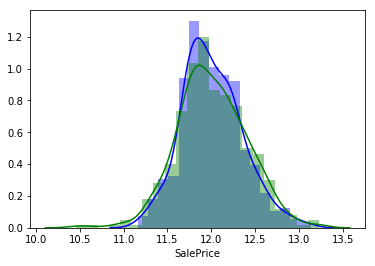

In [495]:
sns.distplot(preds, color='blue')
sns.distplot(y_test, color='green')

In [496]:
submission = pd.read_csv(join(housing_directory, 'sample_submission.csv'))

lr = LinearRegression()
lr.fit(reduced_train, y)

pred = lr.predict(reduced_test)

submission['SalePrice'] = np.exp(pred)

submission.to_csv(join(housing_directory, 'submission.csv'), index=False)

This was really bad. PCA didn't work out.

---
Let's see IsolationForest for outlier removal.

In [497]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest()
is_outlier = isf.fit_predict(train_copy)

outlier_df = pd.DataFrame(is_outlier, index=train_copy.index)
outlier_df.head()

,0
0,1
1,1
2,1
3,1
4,1


In [498]:
outlier_df[0].value_counts()

 1    1334
-1     110
Name: 0, dtype: int64

In [499]:
train_copy.drop(outlier_df[outlier_df[0] == -1].index, inplace=True)

In [500]:
y = np.log(train_copy['SalePrice'])
x = train_copy[['OverallQual', 'GrLivArea', 'TotalBsmtSF']]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.33)

lr = LinearRegression()
lr.fit(x_train, y_train)

lr.score(x_test, y_test)

0.7787284910659398

In [501]:
from sklearn.metrics import mean_squared_error

preds = lr.predict(x_test)
mean_squared_error(y_test, preds)

0.029570774217101782

Not very promising. Gonna stick with the simple one for now.